# Library

In [1]:
# general
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import string
import re
import random

# Visualization
from wordcloud import WordCloud

# NLP
import nltk
from langdetect import detect
from collections import Counter
from nltk.tokenize import TreebankWordTokenizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from symspellpy import SymSpell, Verbosity
from googletrans import Translator

# Text Processing
from operator import itemgetter

# extras
from tqdm import tqdm


In [2]:
random.seed(42)
np.random.seed(42)

In [3]:
df = pd.read_csv('D:/Coding/school/thesis dhewa/scraping/data/aftercovid_greview_dataset-100325.csv')
df.head()

,reviewId,content,score,at,replyContent,appVersion,application
0,3c1c4e4e-8fc1-4041-a1ee-58f7b96874fa,UI/UX consultana abi juaraaaaaaaaaaa,5,2024-11-06 13:43:40,NaN,3.6.2,Sehati Bidan
1,a3821934-258e-4916-b8cb-cd4a2711ae1d,Mohon maaf saya mau registrasi via wa knp blm ...,2,2024-06-23 16:20:11,NaN,3.6.2,Sehati Bidan
2,95c28411-5b84-4e9b-9753-88e0f54d6e0d,TIDAK MEREKOMENDASIKAN APLIKASI YANG SANGAT SA...,1,2023-04-07 07:50:41,NaN,3.6.2,Sehati Bidan
3,903db77d-8504-4f00-8043-fe478d583d30,super app. thanks.,5,2022-09-30 05:41:50,NaN,NaN,Sehati Bidan
4,212c222c-a597-4cac-b5a4-9913dc562b8e,Mudah aplikasinya,5,2022-03-03 06:23:28,"Halo Bidan Esther,\nTerima kasih atas kepercay...",3.5.2,Sehati Bidan


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60428 entries, 0 to 60427
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   reviewId      60428 non-null  object
 1   content       60428 non-null  object
 2   score         60428 non-null  int64 
 3   at            60428 non-null  object
 4   replyContent  56894 non-null  object
 5   appVersion    53289 non-null  object
 6   application   60428 non-null  object
dtypes: int64(1), object(6)
memory usage: 3.2+ MB


## Filtering

I'm not using it, just in case you need to for your further research

### Filter After 2021

In [4]:
df["at"] = pd.to_datetime(df["at"])
df_aft_covid = df[df["at"].dt.year >= 2021]

In [5]:
df_bef_covid = df[df["at"].dt.year <= 2021]

In [6]:
df_aft_covid.count()

Unnamed: 0      6066
reviewId        6066
content         6066
score           6066
at              6066
replyContent    5725
appVersion      5320
application     6066
dtype: int64

### Filtering Score < 3

In [ ]:
df_bad = df[df["score"] <= 3]
df_bad.info()

<class 'pandas.core.frame.DataFrame'>
Index: 321 entries, 2 to 9855
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Unnamed: 0    321 non-null    int64         
 1   reviewId      321 non-null    object        
 2   content       321 non-null    object        
 3   score         321 non-null    int64         
 4   at            321 non-null    datetime64[ns]
 5   replyContent  312 non-null    object        
 6   appVersion    242 non-null    object        
 7   application   321 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 22.6+ KB


In [ ]:
df_good = df[df["score"] <= 3]
df_good.info()

### Sampling (not gonna be used)

In [5]:
df = df.sample(n=15000)

# Preprocessing

In [6]:
df = df[['content']].copy()
df.rename(columns={'content': 'review'}, inplace=True)

In [7]:
df = df[['review']].copy().astype(str)

## Drop Duplicates

> This meant to delete words that are lot of them are duplicated such as "bagus, nice, good, mantab sekali, etc"

In [8]:
df = df.drop_duplicates()
print(f'Reviews left after drop duplicated: {df["review"].count()} reviews')

Reviews left after drop duplicated: 11900 reviews


In [9]:
df

,review
59691,membantu sekali untuk para newmom.. banyak ilm...
54554,"Bagusass,, sangat membantuku memantau tumbuh k..."
20440,Aplikasi yang sangat membantu buat aku 😍. Dari...
25809,Aplikasi yang sangat sangat berguna utk ibu ha...
14872,Sangat membantu😍
...,...
45198,"Comingsoon semua, dari mau upload fto, gerakan..."
37961,I already turned off the notification but the ...
52666,Saya sbg ibu baru sangat terbantu dgn Aplikasi...
11235,Aplikasi kehamilan dan tumbuh kembang anak pal...


## Sentence Level Preprocessing

###  Sentence Check

This translation took pretty long time, if yours don't have other lang data. No need then

In [10]:
translator = Translator()

def translate_partial(sentence):
    words = sentence.split()  # Split sentence into words
    translated_words = []
    
    # Apply tqdm for progress tracking
    for word in tqdm(words, desc="Translating words", leave=False):
        try:
            lang = detect(word)  # Detect language per word
            if lang == "en":  # Only translate English words
                translated_word = translator.translate(word, src="en", dest="id").text
                translated_words.append(translated_word)
            else:
                translated_words.append(word)  # Keep Indonesian words unchanged
        except:
            translated_words.append(word)  # Keep word if detection fails
    
    return " ".join(translated_words)  # Reconstruct the sentence

In [11]:
tqdm.pandas(desc="Processing sentences")
df['processed_review'] = df['review'].progress_apply(translate_partial)
df.head()

Processing sentences: 100%|██████████| 11900/11900 [54:53<00:00,  3.61it/s] 


,review,processed_review
59691,membantu sekali untuk para newmom.. banyak ilm...,membantu sekali untuk para newmom.. banyak ilm...
54554,"Bagusass,, sangat membantuku memantau tumbuh k...","Bagusass,, sangat membantuku memantau tumbuh k..."
20440,Aplikasi yang sangat membantu buat aku 😍. Dari...,Aplikasi yang sangat membantu buat aku 😍. Dari...
25809,Aplikasi yang sangat sangat berguna utk ibu ha...,Aplikasi yang sangat sangat berguna utk ibu ha...
14872,Sangat membantu😍,Sangat membantu😍


In [12]:
df[df['processed_review'] != df['review']].sample(5)

,review,processed_review
21973,Aplikasi theasianparent sangat bagus dan berma...,Aplikasi Theasianparent sangat bagus dan berma...
37053,apps ni bagus untuk first time mom mcm saya. b...,apps ni bagus untuk Pertama time mom mcm saya....
21835,TheAsianparent adalah aplikasi tentang edukasi...,Theasianparent adalah aplikasi tentang edukasi...
23479,TAP ini membantu sekali. Banyak ilmu yg bisa d...,TAP ini membantu sekali. Banyak ilmu yg bisa d...
39192,"Love it. It has all the advises, tips and know...","Love it. Dia has all itu advises, tips Dan pen..."


### Case Folding

In [13]:
def indonesian_case_folding(s):
    """
    Preprocessing teks dalam bahasa Indonesia
    """

    # lower the text
    s = s.lower()

    # Delete html entitiy such as "&gt;" atau "&lt;"
    s = re.sub(r'&gt|&lt', ' ', s)

    # Normalizing repetitive words (ex: "bagusss" -> "bagus")
    s = re.sub(r'([a-z])\1{2,}', r'\1', s)

    # Normalizing repetitive character (ex: "!!!" -> "!")
    s = re.sub(r'([\W+])\1{1,}', r'\1', s)

    # Add space after punctuation
    s = re.sub(f"([{re.escape(string.punctuation)}])(\w)", r"\1 \2", s)

    # Remove punctuation
    s = s.translate(str.maketrans('', '', string.punctuation))

    # Remove inside bracket text
    s = re.sub(r'\(.*?\)', '. ', s)

    # Remove noise
    # s = re.sub(r'product received for free[.| ]', ' ', s)

    # Remove emojis and special character
    s = re.sub(r'[^\w\s.,!?]', '', s)

    return s.strip()

In [14]:
df["processed_review"] = df['review'].apply(indonesian_case_folding)
df.head()

,review,processed_review
59691,membantu sekali untuk para newmom.. banyak ilm...,membantu sekali untuk para newmom banyak ilmu ...
54554,"Bagusass,, sangat membantuku memantau tumbuh k...",bagusass sangat membantuku memantau tumbuh kem...
20440,Aplikasi yang sangat membantu buat aku 😍. Dari...,aplikasi yang sangat membantu buat aku dari s...
25809,Aplikasi yang sangat sangat berguna utk ibu ha...,aplikasi yang sangat sangat berguna utk ibu ha...
14872,Sangat membantu😍,sangat membantu


## Word Level Preprocessing

### Spelling Check

To create a spelling checker we may need a corpus / a dictionary that contains Indonesian words as reference. 
The easiest way is to scrape from the available resources online

In [15]:
# initialize
sym_spell = SymSpell()

# create dictionary
path_corpus = "D:/Coding/school/thesis dhewa/preprocessing/resources/clean_wordlist.txt"
sym_spell.create_dictionary(path_corpus, encoding="utf-8")

True

In [52]:
suggestions = sym_spell.lookup('skit',
                               Verbosity.CLOSEST,
                               max_edit_distance=2,
                               include_unknown=True)
for s in suggestions:
    print(s.term, s.count)

sakit 43
ski 6
kit 3
sit 2
sikit 1
akit 1
sait 1
suit 1
skip 1
skim 1


In [37]:
def correct_sentence(sentence):
    words = sentence.split()  # Split sentence into words
    corrected_words = [
        sym_spell.lookup(w, Verbosity.CLOSEST, max_edit_distance=2, include_unknown=True)[0].term
        if sym_spell.lookup(w, Verbosity.CLOSEST, max_edit_distance=2, include_unknown=True)
        else w  # Keep the word if no suggestion found
        for w in words
    ]
    return " ".join(corrected_words)

In [40]:
df['processed_words'] = df['processed_review'].apply(correct_sentence)
df[df['processed_review'] != df['processed_words']].sample(5)

,review,processed_review,processed_words
54093,"isi aplikasinya lengkap, mudah banget dipahami...",isi aplikasinya lengkap mudah banget dipahami ...,isi aplikasinya lengkap mudah banget dipahat b...
40981,This app really help me as a 1st time mom. Fro...,this app really help me as a 1st time mom from...,his api realis helm me as a est time bom fron ...
19820,Asik banget semenjak pake aplikasi theasianpar...,asik banget semenjak pake aplikasi theasianpar...,asik banget semenjak paku aplikasi theasianpar...
1885,"Aplikasinya sangat bagus, membantu sekali untu...",aplikasinya sangat bagus membantu sekali untuk...,aplikasinya sangat bagus membantu sekali untuk...
52102,aplikasi lengkap..tmbh byk ilmu ttg seputar ke...,aplikasi lengkap tmbh byk ilmu ttg seputar keh...,aplikasi lengkap tubuh bak ilmu tt seputar keh...


### Fix slang words

In [17]:
# first dictionary - "new_kamusalay.csv"
alay_dict = pd.read_csv(
    'D:/Coding/school/thesis dhewa/preprocessing/resources/new_kamusalay.csv',
    names=['original', 'replacement'],  # Set column names manually
    encoding='latin-1'
)

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))

In [18]:
# second dictionary - "combined_slang_words.txt"
with open('D:/Coding/school/thesis dhewa/preprocessing/resources/combined_slang_words.txt', 'r', encoding='utf-8') as file:
    slang_dict_txt = json.load(file)

In [19]:
# merge both dictionary and function
combined_slang_dict = {**alay_dict_map, **slang_dict_txt}

def normalize_slang(text):
    words = text.split()
    normalized_text = ' '.join([combined_slang_dict.get(word, word) for word in words])
    return normalized_text

In [23]:
df['processed_words'] = df['processed_review'].apply(normalize_slang)
df[['processed_review', 'processed_words']][df['processed_review'] != df['processed_words']].sample(5)

,processed_review,processed_words
57973,alhamdulillah sangat membantu untuk aku yg bru...,alhamdulillah sangat membantu untuk aku yang b...
128,bagus tpi knpa ya sudah di minggu 30 engga di ...,bagus tapi kenapa iya sudah di minggu 30 tidak...
19140,aplikasi yg sangat sangat membantu sekali,aplikasi yang sangat sangat membantu sekali
60319,ibaratnya dunia pelayanan aplikasi ini benar2 ...,ibaratnya dunia pelayanan aplikasi ini benar b...
54064,best application ever very recommended nih mom...,best application ever sangat recommended ini m...


In [32]:
df.loc[49130]

review              Senang sekali dengan aplikasi Teman Bumil yang...
processed_review    senang sekali dengan aplikasi teman bumil yang...
processed_words     senang sekali dengan aplikasi teman ibu hamil ...
Name: 49130, dtype: object

it even fix the "bumil" to a normalize "ibu hamil" ANJAAAAAYYYYYYYYYYYYYY

### Tokenize Text

In [34]:
tokenizer = TreebankWordTokenizer()

# apply
df['tokenized_words'] = df['processed_words'].apply(tokenizer.tokenize)

In [35]:
df.head()

,review,processed_review,processed_words,tokenized_words
59691,membantu sekali untuk para newmom.. banyak ilm...,membantu sekali untuk para newmom banyak ilmu ...,membantu sekali untuk para newmom banyak ilmu ...,"[membantu, sekali, untuk, para, newmom, banyak..."
54554,"Bagusass,, sangat membantuku memantau tumbuh k...",bagusass sangat membantuku memantau tumbuh kem...,bagusass sangat membantuku memantau tumbuh kem...,"[bagusass, sangat, membantuku, memantau, tumbu..."
20440,Aplikasi yang sangat membantu buat aku 😍. Dari...,aplikasi yang sangat membantu buat aku dari s...,aplikasi yang sangat membantu buat aku dari se...,"[aplikasi, yang, sangat, membantu, buat, aku, ..."
25809,Aplikasi yang sangat sangat berguna utk ibu ha...,aplikasi yang sangat sangat berguna utk ibu ha...,aplikasi yang sangat sangat berguna untuk ibu ...,"[aplikasi, yang, sangat, sangat, berguna, untu..."
14872,Sangat membantu😍,sangat membantu,sangat membantu,"[sangat, membantu]"


### Stemming

In [36]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

stem_factory = factory.get_words()

In [37]:
# add more words from "combined_root_words.txt"
with open('D:/Coding/school/thesis dhewa/preprocessing/resources/combined_root_words.txt', 'r', encoding='utf-8') as f:
    root_words = f.read().splitlines()
    
all_root_words = list(set(stem_factory + root_words))

In [38]:
def custom_stem(word):
    if word in all_root_words:
        return word 
    return stemmer.stem(word)

In [39]:
# apply
tqdm.pandas() 
df['processed_tokenized'] = df['tokenized_words'].progress_apply(
    lambda words: [custom_stem(word) for word in words]
)

df[['tokenized_words', 'processed_tokenized']][df['tokenized_words'] != df['processed_tokenized']].sample(5)

100%|██████████| 11900/11900 [12:10<00:00, 16.28it/s]


,tokenized_words,processed_tokenized
59341,"[aplikasi, yang, super, lengkap, berguna, bang...","[aplikasi, yang, super, lengkap, guna, banget,..."
14339,"[aplikasi, ini, sangat, menarik, dan, membantu...","[aplikasi, ini, sangat, tarik, dan, bantu, par..."
19334,"[menurut, saya, aplikasi, theasianparent, ini,...","[turut, saya, aplikasi, theasianparent, ini, s..."
29983,"[hamil, dan, perlu, pemantauan, dari, aplikasi...","[hamil, dan, perlu, pantau, dari, aplikasi, in..."
46325,"[semoga, hamil, anak, ke, dua, cewk, amin]","[moga, hamil, anak, ke, dua, cewk, amin]"


In [41]:
df.head()

,review,processed_review,processed_words,tokenized_words,processed_tokenized
59691,membantu sekali untuk para newmom.. banyak ilm...,membantu sekali untuk para newmom banyak ilmu ...,membantu sekali untuk para newmom banyak ilmu ...,"[membantu, sekali, untuk, para, newmom, banyak...","[bantu, sekali, untuk, para, newmom, banyak, i..."
54554,"Bagusass,, sangat membantuku memantau tumbuh k...",bagusass sangat membantuku memantau tumbuh kem...,bagusass sangat membantuku memantau tumbuh kem...,"[bagusass, sangat, membantuku, memantau, tumbu...","[bagusass, sangat, bantu, pantau, tumbuh, kemb..."
20440,Aplikasi yang sangat membantu buat aku 😍. Dari...,aplikasi yang sangat membantu buat aku dari s...,aplikasi yang sangat membantu buat aku dari se...,"[aplikasi, yang, sangat, membantu, buat, aku, ...","[aplikasi, yang, sangat, bantu, buat, aku, dar..."
25809,Aplikasi yang sangat sangat berguna utk ibu ha...,aplikasi yang sangat sangat berguna utk ibu ha...,aplikasi yang sangat sangat berguna untuk ibu ...,"[aplikasi, yang, sangat, sangat, berguna, untu...","[aplikasi, yang, sangat, sangat, guna, untuk, ..."
14872,Sangat membantu😍,sangat membantu,sangat membantu,"[sangat, membantu]","[sangat, bantu]"


### Stopwords

In [42]:
# Load stopwords file
def load_stopwords(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        stop_words = set(f.read().splitlines())
    return stop_words

# Remove stopwords from tokenized lists
def remove_stopwords(tokenized_text, stop_words):
    """Remove stopwords from a tokenized list of words."""
    return [word for word in tokenized_text if word not in stop_words]

In [43]:
# Load stopwords
stop_words = load_stopwords('D:/Coding/school/thesis dhewa/preprocessing/resources/combined_stop_words.txt')

# apply
df['no_stopwords'] = df['processed_tokenized'].progress_apply(lambda text: remove_stopwords(text, stop_words))

df.head()

100%|██████████| 11900/11900 [00:00<00:00, 44964.67it/s]


,review,processed_review,processed_words,tokenized_words,processed_tokenized,no_stopwords
59691,membantu sekali untuk para newmom.. banyak ilm...,membantu sekali untuk para newmom banyak ilmu ...,membantu sekali untuk para newmom banyak ilmu ...,"[membantu, sekali, untuk, para, newmom, banyak...","[bantu, sekali, untuk, para, newmom, banyak, i...","[bantu, newmom, ilmu, ajar, pantau, tumbang, a..."
54554,"Bagusass,, sangat membantuku memantau tumbuh k...",bagusass sangat membantuku memantau tumbuh kem...,bagusass sangat membantuku memantau tumbuh kem...,"[bagusass, sangat, membantuku, memantau, tumbu...","[bagusass, sangat, bantu, pantau, tumbuh, kemb...","[bagusass, bantu, pantau, tumbuh, kembang, anak]"
20440,Aplikasi yang sangat membantu buat aku 😍. Dari...,aplikasi yang sangat membantu buat aku dari s...,aplikasi yang sangat membantu buat aku dari se...,"[aplikasi, yang, sangat, membantu, buat, aku, ...","[aplikasi, yang, sangat, bantu, buat, aku, dar...","[aplikasi, bantu, semenjak, hamil, anak, usia,..."
25809,Aplikasi yang sangat sangat berguna utk ibu ha...,aplikasi yang sangat sangat berguna utk ibu ha...,aplikasi yang sangat sangat berguna untuk ibu ...,"[aplikasi, yang, sangat, sangat, berguna, untu...","[aplikasi, yang, sangat, sangat, guna, untuk, ...","[aplikasi, ibu, hamil, suka, aplikasi, satu ny..."
14872,Sangat membantu😍,sangat membantu,sangat membantu,"[sangat, membantu]","[sangat, bantu]",[bantu]


## Create Corpus

In [53]:
corpus = []

for row in tqdm(range(len(df['no_stopwords']))):
    for word in df['no_stopwords'].iloc[row]:
        corpus.append(word)

corpus[0:20]

100%|██████████| 11900/11900 [00:00<00:00, 103358.68it/s]


['bantu',
 'newmom',
 'ilmu',
 'ajar',
 'pantau',
 'tumbang',
 'anak',
 'skrining',
 'vaksinasi',
 'resep',
 'mpasi',
 'belanja',
 'dalam',
 '1',
 'aplikasi',
 'bagusass',
 'bantu',
 'pantau',
 'tumbuh',
 'kembang']

In [54]:
# save to a file
with open("export/corpus.txt", "w", encoding="utf-8") as f:
    for word in corpus:
        f.write(word + "\n")

# Visualize

## WordCloud

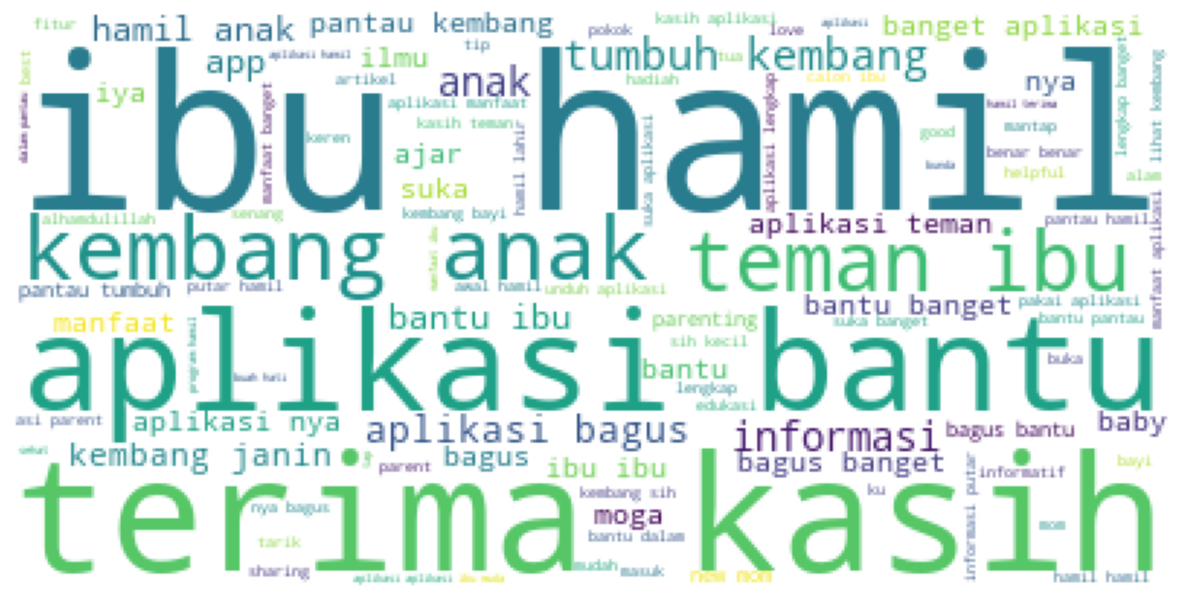

In [55]:
fig = plt.figure(figsize=(15,12))
word_cloud = WordCloud(background_color='white', max_font_size=80, max_words=100).generate(' '.join(corpus))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

## Most Frequent Words

In [57]:
counter = Counter()

for i in tqdm(range(len(df['no_stopwords']))):
  for word in df['no_stopwords'].iloc[i]:
      counter[word] += 1


counter = dict(counter)

100%|██████████| 11900/11900 [00:00<00:00, 72792.61it/s]


In [58]:
# 10 most frequent words from corpus

top_10_words = dict(sorted(counter.items(), key = itemgetter(1), reverse = True)[:10])
words = [x for x in top_10_words.keys()]
counts = [x for x in top_10_words.values()]
data = {'words': words, 'counts': counts}
top_10_words = pd.DataFrame(data, columns=['words', 'counts'])
top_10_words

,words,counts
0,aplikasi,6458
1,hamil,5543
2,bantu,4369
3,anak,4015
4,ibu,3941
5,kembang,2808
6,banget,2514
7,bagus,2105
8,kasih,1687
9,informasi,1611


C:\Users\GF63\AppData\Local\Temp\ipykernel_8080\3317012872.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


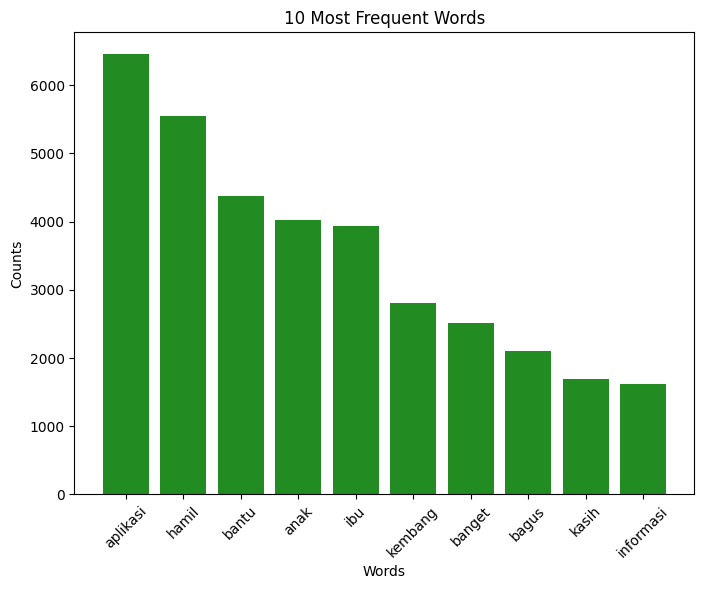

In [59]:
# plot

fig = plt.figure(figsize=(8,6))
plt.bar(top_10_words['words'], top_10_words['counts'], color='forestgreen')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.title('10 Most Frequent Words')
plt.legend().set_visible(False)
plt.show()

# Export

Adjust the variables according to your need

In [60]:
df['final_sentence'] = df['processed_tokenized'].apply(lambda words: ' '.join(words))
df

,review,processed_review,processed_words,tokenized_words,processed_tokenized,no_stopwords,final_sentence
59691,membantu sekali untuk para newmom.. banyak ilm...,membantu sekali untuk para newmom banyak ilmu ...,membantu sekali untuk para newmom banyak ilmu ...,"[membantu, sekali, untuk, para, newmom, banyak...","[bantu, sekali, untuk, para, newmom, banyak, i...","[bantu, newmom, ilmu, ajar, pantau, tumbang, a...",bantu sekali untuk para newmom banyak ilmu yan...
54554,"Bagusass,, sangat membantuku memantau tumbuh k...",bagusass sangat membantuku memantau tumbuh kem...,bagusass sangat membantuku memantau tumbuh kem...,"[bagusass, sangat, membantuku, memantau, tumbu...","[bagusass, sangat, bantu, pantau, tumbuh, kemb...","[bagusass, bantu, pantau, tumbuh, kembang, anak]",bagusass sangat bantu pantau tumbuh kembang anak
20440,Aplikasi yang sangat membantu buat aku 😍. Dari...,aplikasi yang sangat membantu buat aku dari s...,aplikasi yang sangat membantu buat aku dari se...,"[aplikasi, yang, sangat, membantu, buat, aku, ...","[aplikasi, yang, sangat, bantu, buat, aku, dar...","[aplikasi, bantu, semenjak, hamil, anak, usia,...",aplikasi yang sangat bantu buat aku dari semen...
25809,Aplikasi yang sangat sangat berguna utk ibu ha...,aplikasi yang sangat sangat berguna utk ibu ha...,aplikasi yang sangat sangat berguna untuk ibu ...,"[aplikasi, yang, sangat, sangat, berguna, untu...","[aplikasi, yang, sangat, sangat, guna, untuk, ...","[aplikasi, ibu, hamil, suka, aplikasi, satu ny...",aplikasi yang sangat sangat guna untuk ibu ham...
14872,Sangat membantu😍,sangat membantu,sangat membantu,"[sangat, membantu]","[sangat, bantu]",[bantu],sangat bantu
...,...,...,...,...,...,...,...
45198,"Comingsoon semua, dari mau upload fto, gerakan...",comingsoon semua dari mau upload fto gerakan d...,comingsoon semua dari mau unggah foto gerakan ...,"[comingsoon, semua, dari, mau, unggah, foto, g...","[comingsoon, semua, dari, mau, unggah, foto, g...","[comingsoon, unggah, foto, gera, adik, bayi, b...",comingsoon semua dari mau unggah foto gera adi...
37961,I already turned off the notification but the ...,i already turned off the notification but the ...,i already turned off the notification but the ...,"[i, already, turned, off, the, notification, b...","[i, already, turned, off, the, notification, b...","[i, already, turned, off, notification, but, a...",i already turned off the notification but the ...
52666,Saya sbg ibu baru sangat terbantu dgn Aplikasi...,saya sbg ibu baru sangat terbantu dgn aplikasi...,saya sebagai ibu baru sangat terbantu dengan a...,"[saya, sebagai, ibu, baru, sangat, terbantu, d...","[saya, bagai, ibu, baru, sangat, bantu, dengan...","[ibu, bantu, aplikasi, hamil, anak, usia, 9bln...",saya bagai ibu baru sangat bantu dengan aplika...
11235,Aplikasi kehamilan dan tumbuh kembang anak pal...,aplikasi kehamilan dan tumbuh kembang anak pal...,aplikasi kehamilan dan tumbuh kembang anak pal...,"[aplikasi, kehamilan, dan, tumbuh, kembang, an...","[aplikasi, hamil, dan, tumbuh, kembang, anak, ...","[aplikasi, hamil, tumbuh, kembang, anak, lengk...",aplikasi hamil dan tumbuh kembang anak paling ...


In [63]:
df.to_csv('export/preprocessed_sample_greview_dataset-100325.csv', index=False)

In [258]:
df_aft_covid['processed_tokenized'].to_csv('export/tokenized_processed_df.csv', index=False, header=False)
df_aft_covid['final_sentence'].to_csv('export/processed_df.csv', index=False, header=False)